---
Trabalho Prático 01 da Disciplina DCC207 - Algoritmos 2
# Geometria Computacional e Classificação Linear
---
Alunos:
- Juan Braga
- Lucas Almeida
- Luiz Romanhol

# 1. Introdução

O objetivo deste trabalho é empregar algoritmos de `geometria computacional` para a criação de um modelo de `classificação linear`.

**Descrição:** A partir de um conjunto de dados de treinamento, o algoritmo deve encontrar uma envoltória (contorno) que delimite uma região de classificação para um conjunto de dados (pontos no plano cartesiano). A partir de duas dessas envoltórias, será possível determinar se há separabilidade (ou se elas tem áreas sobrepostas) e então determinar uma reta que separe os dois conjuntos de dados.

**Apresentação do modelo:** Cada etapa do algoritmo será apresentada e explicada separadamente, e utilizará um conjunto de dados aleatório gerado a cada execução. O leitor pode livremente re-executar as células das seções 1 a 5 para visualizar conjuntos de dados diferentes.

Passos envolvidos no modelo (enumerado segundo as seções deste documento/arquivo):
2. Envoltória Convexa (encontrar o contorno)

3. Varredura Linear (definir separabilidade/sobreposição entre modelos)

4. Modelo de Classificação (encontrar a reta de separabilidade)

5. Classificador e cálculo de métricas (computar teste e calcular precisão do modelo gerado)

Uma vez apresentado o algoritmo e sua interface definida, serão realizados testes e calculadas métricas de precisão para o modelo em diferentes bases de dados.

## 1.1 Primitivas
Para a execução dos algoritmos de geometria computacional, serão utilizadas algumas primitivas apresentadas em aula:

**Inicializando bibliotecas**

In [520]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import functools
import pandas as pd
import seaborn as sns

> A função `orientacao()` determina a orientação relativa entre três pontos no plano cartesiano. A partir da determinação do sinal do determinante da matriz formada pelos três pontos, é possível determinar se os pontos estão em sentido horário, anti-horário ou colineares. Com esta informação, se soubermos que dois pontos pertencem a uma reta, podemos determinar para qual lado o terceiro ponto está.

Tal escolha almeja evitar operações de divisão entre os pontos, que podem produzir imprecisões indesejadas que podem se propagar ao longo do algoritmo (o fenômeno chamado de *underflow*).

Seguindo o Teorema 22.1 do livro Algorithm Design and Applications (por Goodrich e Tamassia), de 2015.

In [521]:
def orientacao(p, q, r):
	"""Retorna a orientação do caminho P-Q-R
	:params p, q, r: pontos
	:return: 0 = colinear, 1 = sentido horário, 2 = sentido anti-horário
	"""
	val = (q[1] - p[1]) * (r[0] - q[0]) - \
		  (q[0] - p[0]) * (r[1] - q[1])

	if val == 0:
		return 0
	elif val > 0:
		return 1
	else:
		return 2

> Aqui, o uso da distância quadrada na função `distanciaQuadrada` também se dá para evitar o uso de divisão em operações mais tradicionais, como a Distância Euclidiana.

In [522]:
def distanciaQuadrada(ancora, ponto):
	"""Retorna o quadrado da distância entre o ponto âncora e o ponto dado"""
	dist_ancora_ponto = (ponto[0] - ancora[0])**2 + (ponto[1] - ancora[1])**2
	return dist_ancora_ponto

> Uma função para determinar se um dado ponto está sobre um segmento de linha (um par de pontos).

In [523]:
def estaNoSegmento(segment, point):
	"""Retorna True se o ponto está no segmento de linha"""
	if (point[0] <= max(segment[0][0], segment[1][0]) and \
		point[0] >= min(segment[0][0], segment[1][0]) and \
		point[1] <= max(segment[0][1], segment[1][1]) and \
		point[1] >= min(segment[0][1], segment[1][1])):
		return True
	return False

A função `segmentosInterceptam` determina se dois segmentos se interceptam.

Como cada segmento é representado como um par de pontos no plano cartesiano, a função `orientacao` é utilizada para determinar se cada ponto de um segmento está de um lado diferente do outro segmento.

In [524]:
def segmentosInterceptam(seg1, seg2):
	"""Retorna True se os segmentos se interceptam"""

	# não considera interseção se os segmentos compartilham um vértice
	if np.array([seg1[0] == seg2[0], seg1[0] == seg2[1], seg1[1] == seg2[0], seg1[1] == seg2[1]]).any():
		return False

	d1 = orientacao(seg2[0], seg2[1], seg1[0])
	d2 = orientacao(seg2[0], seg2[1], seg1[1])
	d3 = orientacao(seg1[0], seg1[1], seg2[0])
	d4 = orientacao(seg1[0], seg1[1], seg2[1])

	if (d1==1 and d2==2) or (d1==2 and d2==1) and \
	   (d3==1 and d4==2) or (d3==2 and d4==1):
		return True
	elif (d1==0 and estaNoSegmento(seg2, seg1[0])) or \
		 (d2==0 and estaNoSegmento(seg2, seg1[1])) or \
		 (d3==0 and estaNoSegmento(seg1, seg2[0])) or \
		 (d4==0 and estaNoSegmento(seg1, seg2[1])):
		return True
	return False

## 1.2 Funções auxiliares

Para a implementação do algoritmo, serão aqui inicializadas bibliotecas e definidas funções para gerar conjuntos de dados aleatórios e também "plotá-los".

**Geração de pontos:**

> Função `geraRect` produz uma nuvem de pontos aleatórios dentro de um retângulo (bom para produzir casos com pontos colineares ao âncora)

> Função `geraCirc` produz uma nuvem de pontos aleatórios dentro de um círculo.

> Função `geraPontos` escolhe aleatóriamente entre `geraRect` e `geraCirc` para gerar os pontos.

> Função `plotaPontos` usa a biblioteca matplotlib para visualizar um conjunto de pontos.

In [525]:
def geraRect(num, intervalo):
	"""Gera pontos aleatórios dentro de um retângulo"""
	pontos = []
	for _ in range(num):

		# Gera um ponto aleatório dentro do intervalo
		x = random.randint(intervalo[0], intervalo[1])
		y = random.randint(intervalo[0], intervalo[1])

		pontos.append((x,y))
	return pontos

In [526]:
def geraCirc(num, intervalo=(50,100)):
	"""Gera pontos aleatórios dentro de um círculo"""
	pontos = []

	# pega o menor valor do intervalo para usar como raio
	raio_maximo = min(intervalo)

	for _ in range(num):

		# Gera um ângulo aleatório entre 0 e 2*pi (360 graus)
		angulo = random.uniform(0, 2 * math.pi)

		# Gera um raio aleatório entre 0 e o raio máximo
		raio = random.uniform(0, raio_maximo)

		# Converte coordenadas polares em coordenadas cartesianas centradas no meio do intervalo
		x = raio * math.cos(angulo) + 1.5*intervalo[0]
		y = raio * math.sin(angulo) + 1.5*intervalo[0]

		pontos.append((int(x), int(y)))

	return pontos

In [527]:
def geraPontos(num=200, intervalo=(50,100)):
	"""Gera pontos aleatórios dentro de um retângulo ou círculo"""
	pontos = []

	aleatorio = random.randint(0,1)

	if aleatorio == 0:
		pontos = geraRect(num, intervalo)
	else:
		pontos = geraCirc(num, intervalo)

	return pontos

In [528]:
def plotaPontos(pontos):
	plt.scatter(*zip(*pontos), s=5, c='black')
	plt.show()

In [529]:
def desenha_pontos(points_1, points_2, label_1, label_2):
    # Defina cores personalizadas para cada classe
    colors = ['red', 'green']

    # Crie um gráfico de dispersão com cores mapeadas para os pontos das duas classes
    plt.scatter(points_1[:, 0], points_1[:, 1], c=colors[0], label=label_1)
    plt.scatter(points_2[:, 0], points_2[:, 1], c=colors[1], label=label_2)

    # Adicione a legenda com os rótulos descritivos e as cores correspondentes
    plt.legend()

**Plotar o desenho da envoltória**

In [530]:
def desenhaEnvoltoria(envoltoria, pontos=None, show=False):
	"""
	Plota os pontos, e os segmentos da envoltória em vermelho
	:param pontos: Lista de pontos
	:param envoltoria: Lista de pontos que formam a envoltória convexa
	:param show: Se False, apenas gera o plot. Se True, gera o plot e mostra
	:return: None
	"""
	if pontos is None:
			pontos = envoltoria

	x, y = zip(*pontos)
	plt.scatter(x, y, s=5, c='black')

	# plt.xlim(0, 1.5*max(x))
	# plt.ylim(0, 1.5*max(y))

	for i in range(len(envoltoria)):
		x = (envoltoria[i][0], envoltoria[(i + 1) % len(envoltoria)][0])
		y = (envoltoria[i][1], envoltoria[(i + 1) % len(envoltoria)][1])

		# plota o segmento de linha entre o ponto atual e o próximo ponto
		plt.plot(x, y, color='red')

	if show:
		plt.show()

# 2. Envoltória Convexa

O primeiro passo para a criação do modelo é encontrar o contorno de um dado conjunto de dados (pontos no plano). Para isso, foi escolhido o algoritmo da `Envoltória Convexa de Graham`.

> **Descrição do algoritmo:**
1. Encontrar o ponto com menor coordenada y (se houver empate, escolher o de menor coordenada x). Este ponto é chamado de âncora.
2. Ordenar os pontos restantes em ordem crescente de acordo com o ângulo que eles formam com o âncora e a horizontal.
3. Iniciar uma pilha vazia.
4. Empilhar o âncora e o primeiro ponto da ordenação.
5. Para cada ponto restante, enquanto a orientação formada pelos três pontos do topo da pilha for anti-horária, desempilhar o topo da pilha.
6. Empilhar o ponto restante.

Note que a principal parte do algoritmo se trata do critério com o qual os pontos são ordenados no passo 2. As primitivas `orientacao` e `distanciaQuadrada` são essenciais, pois permitem definir o "ângulo polar" relativo entre cada um dos pontos em relação ao ponto âncora, sem usar operações de divisão (como a `atan2` da biblioteca `math`).

In [531]:
def envoltoriaConvexa(pontos):
	"""
	Calcula a envoltória convexa de uma lista de pontos.
	:return: Lista de pontos que formam a envoltória convexa
	"""
	# Faz com que a entrada seja uma lista se for dada uma instância de np.array
	pontos = list(pontos)

	# Se houver menos de 3 pontos, não há envoltória convexa
	if len(pontos) <= 3:
		return None

	# Encontre o ponto âncora com a menor coordenada y (e menor x se houver empate)
	ponto_ancora = min(pontos, key=lambda p: (p[1], p[0]))

	# Função dentro do escopo de envoltoriaConvexa() para acessar a variável ponto_ancora
	def comparaAngulos(p1, p2):
		"""Função auxiliar para ordenar os pontos por ângulo polar"""
		direcao = orientacao(ponto_ancora, p1, p2)
		if direcao == 0:
			if distanciaQuadrada(ponto_ancora, p2) >= distanciaQuadrada(ponto_ancora, p1):
				return -1
			else:
				return 1
		elif direcao == 2:
			return -1
		else:
			return 1

	# Ordena os pontos por ângulo polar em relação ao ponto âncora (e maior distância se houver empate)
	pontos = sorted(pontos, key=functools.cmp_to_key(comparaAngulos))

	# move o ancora para o inicio da lista (a função sortnão garante permanência de elementos empatados)
	pontos.remove(ponto_ancora)
	pontos.insert(0, ponto_ancora)

	# cria uma pilha e insere os três primeiros pontos nela
	pilha = []
	pilha.append(pontos[0])
	pilha.append(pontos[1])
	pilha.append(pontos[2])

	for i in range(3, len(pontos)):
		# continue removendo o topo enquanto o último ponto e o ponto atual fazem um ângulo horário ou são colineares
		while len(pilha) > 1 and orientacao(pilha[-2], pilha[-1], pontos[i]) != 2:
			pilha.pop()
		pilha.append(pontos[i])

	return pilha

**Visualizando a envoltória encontrada**

Utilizando as funções auxiliares da Seção 1, vamos criar uma nuvem de pontos aleatória e checar como a envoltória ficará no plano cartesiano.

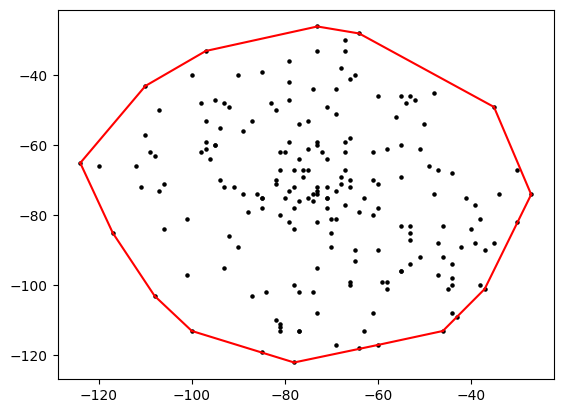

In [532]:
p = geraPontos(200, (-50,0))
env = envoltoriaConvexa(p)

desenhaEnvoltoria(env, p, show=True)

# 3. Varredura Linear

O segundo passo para a criação do modelo, uma vez que já temos duas envoltórias convexas, é determinar se elas são separáveis ou não (isto é, se há sobreposição entre as áreas das envoltórias). Para isso foi escolhido o algoritmo da `Varredura Linear`.

Ele consiste em descobrir se os lados dos polígonos (envoltórias) se cruzam. Isto é feito ao percorrer os pontos da esquerda para a direita, verificando se as retas próximas se encontram com a reta que contém o ponto atual (utilizando a primitiva `orientacao`, veja a seção 1.1 para maiores detalhes).

O principal componente do algritmo da varredura é sua ordenação, pois é ela que irá ditar sua complexidade assintótica de tempo. Assim, definimos primeiro a implementação de uma `árvore binária balanceada` para garantir uma complexidade $O(n*\log(n))$, que irá ordenar os pontos de acordo com a coordenada y de cada *endpont* (pontos que compõem cada uma das retas).

In [533]:
# possíveis posições de um ponto em relação a um segmento
esquerda, direita = 0, 1

class EndPoint:
	"""Representa um ponto de varredura
	:param ponto: ponto de varredura
	:param posicao: posição do ponto em relação ao segmento (início ou fim)
	:param numSegmento: número do segmento ao qual o ponto pertence"""
	def __init__(self, ponto, posicao, numSegmento):
		self.ponto = ponto
		self.posicao = posicao
		self.numSegmento = numSegmento

class No:
	"""Representa um nó de uma árvore binária balanceada
	:param data: dado armazenado no nó
	:param esquerda: filho esquerdo
	:param direita: filho direito"""
	def __init__(self, data):
		self.data = data
		self.setaFilhos(None, None)

	def setaFilhos(self, esquerda, direita):
		self.esquerda = esquerda
		self.direita = direita

	def balanco(self):
		prof_esq = 0
		if self.esquerda:
			prof_esq = self.esquerda.profundidade()
		prof_dir = 0
		if self.direita:
			prof_dir = self.direita.profundidade()
		return prof_esq - prof_dir

	def profundidade(self):
		prof_esq = 0
		if self.esquerda:
			prof_esq = self.esquerda.profundidade()
		prof_dir = 0
		if self.direita:
			prof_dir = self.direita.profundidade()
		return 1 + max(prof_esq, prof_dir)

	def rotacaoEsquerda(self):
		self.data, self.direita.data = self.direita.data, self.data
		old_esquerda = self.esquerda
		self.setaFilhos(self.direita, self.direita.direita)
		self.esquerda.setaFilhos(old_esquerda, self.esquerda.esquerda)

	def rotacaoDireita(self):
		self.data, self.esquerda.data = self.esquerda.data, self.data
		old_direita = self.direita
		self.setaFilhos(self.esquerda.esquerda, self.esquerda)
		self.direita.setaFilhos(self.direita.direita, old_direita)

	def rotacaoEsquerdaDireita(self):
		self.esquerda.rotacaoEsquerda()
		self.rotacaoDireita()

	def rotacaoDireitaEsquerda(self):
		self.direita.rotacaoDireita()
		self.rotacaoEsquerda()

	def executaBalanco(self):
		bal = self.balanco()
		if bal > 1:
			if self.esquerda.balanco() > 0:
				self.rotacaoDireita()
			else:
				self.rotacaoEsquerdaDireita()
		elif bal < -1:
			if self.direita.balanco() < 0:
				self.rotacaoEsquerda()
			else:
				self.rotacaoDireitaEsquerda()

	def insere(self, data, func):
		"""Insere um nó na árvore binária de busca com base em uma função do tipo (data, data) -> bool"""
		if func(data, self.data):
			if not self.esquerda:
				self.esquerda = No(data)
			else:
				self.esquerda.insere(data, func)
		else:
			if not self.direita:
				self.direita = No(data)
			else:
				self.direita.insere(data, func)
		self.executaBalanco()

	def remove(self, data, func):
		"""Remove um nó da árvore binária de busca com base em uma função do tipo (data, data) -> bool"""
		if self.data == data:
			if self.esquerda:
				self.data = self.esquerda.maximo()
				self.esquerda.remove(self.data, func)
			elif self.direita:
				self.data = self.direita.minimo()
				self.direita.remove(self.data, func)
			else:
				self.data = None
		elif self.esquerda and func(data, self.data):
			self.esquerda.remove(data, func)
		elif self.direita and not func(data, self.data):
			self.direita.remove(data, func)
		self.executaBalanco()

	def acima(self, ponto):
		if self.data.ponto[1] <= ponto[1]:
			return self.data
		else:
			if self.esquerda:
				return self.esquerda.acima(ponto)
			else:
				return None

	def abaixo(self, ponto):
		if self.data.ponto[1] >= ponto[1]:
			return self.data
		else:
			if self.direita:
				return self.direita.abaixo(ponto)
			else:
				return None

Antes de realizar a varredura, é necessário perparar os dados. Note que as envoltórias são retornadas do `Algoritmo de Graham` na forma de lista de pontos, enquanto a função `varreduraLinear` espera uma lista de segmentos (pares de pontos). Portanto, é necessário converter as listas de pontos das duas envoltórias em uma única lista de segmentos.

A função `preparaSegmentos` recebe as duas listas de pontos das envoltórias e retorna a lista de segmentos pronta para a varredura linear.

In [534]:
def preparaSegmentos(envoltoria1, envoltoria2):
	"""Formata as envoltórias para a varredura linear"""
	segmentos1 = [(envoltoria1[i], envoltoria1[(i+1)%len(envoltoria1)]) for i in range(len(envoltoria1))]
	segmentos2 = [(envoltoria2[i], envoltoria2[(i+1)%len(envoltoria2)]) for i in range(len(envoltoria2))]

	segmentosVarredura = segmentos1 + segmentos2
	return segmentosVarredura

>**Descrição do algoritmo:**
1. Criar a lista de pontos com as extremidades dos segmentos.
2. Ordenar a lista pelas coordenadas `x` dos pontos e, em caso dê empate, colocar uma extremidade esquerda de um segmento antes da extremidade direita de outro.
3. Criar árvore binária com o primeiro ponto da lista.
4. Para cada segmento da lista:
	1. Se for uma extremidade esquerda, insere na árvore e verifica interseção do segmento com os segmentos logo acima e logo abaixo.
	2. Se for uma extremidade direita, verifica interseção entre os segmentos logo acima e logo abaixo do segmento e remove o segmento
5. Se em alguma verificação houver segmento, retorna `True`. Se percorrer todo o vetor e não houverem interseções, retorna `False`.

In [535]:
def varreduraLinear(segmentos):
	"""Verifica se há interseção entre segmentos em tempo O(n log n)
	:param segmentos: lista de segmentos de linha
	:return: True se há interseção, False caso contrário"""
	pontosVarredura = []
	for i in range(len(segmentos)):
		pontosVarredura.append(EndPoint(segmentos[i][0], esquerda, i))
		pontosVarredura.append(EndPoint(segmentos[i][1], direita, i))

	# 	# produz uma perturbação por causa de possíveis pontos de varredura com x e y repetido
	# for i in range(len(pontosVarredura)):
	# 	pontosVarredura[i].ponto = (pontosVarredura[i].ponto[0], pontosVarredura[i].ponto[1] + i*0.0000001)

	# ordena os pontos de varredura por x e pelo endpoint da esquerda em caso de empate
	pontosVarredura.sort(key=lambda endPoint: (endPoint.ponto[0], endPoint.posicao))

	# árvore binária de busca
	arvore = No(pontosVarredura[0])

	# varre os pontos de varredura
	for endpoint in pontosVarredura:
		cima = arvore.acima(endpoint.ponto)
		baixo = arvore.abaixo(endpoint.ponto)

		if endpoint.posicao == esquerda:
			arvore.insere(endpoint, lambda a, b: a.ponto[1] <= b.ponto[1])

			if cima != None and \
			segmentosInterceptam(segmentos[cima.numSegmento], segmentos[endpoint.numSegmento]):
				return True
			elif baixo != None and \
			segmentosInterceptam(segmentos[baixo.numSegmento], segmentos[endpoint.numSegmento]):
				return True

		if endpoint.posicao == direita:
			if cima != None and baixo != None:
				if segmentosInterceptam(segmentos[cima.numSegmento], segmentos[baixo.numSegmento]):
					return True
			arvore.remove(endpoint, lambda a, b: a.ponto[1] <= b.ponto[1])
	return False

**Visualizando as envoltórias e definindo a sobreposição.**

Utilizando as funções auxiliares da Seção 1, vamos criar duas nuvens de pontos e verificar se há sobreposição entre seus contornos (envoltórias).

Execute quantas vezes precisar, há chances dos conjuntos se sobreporem ou não a cada execução.

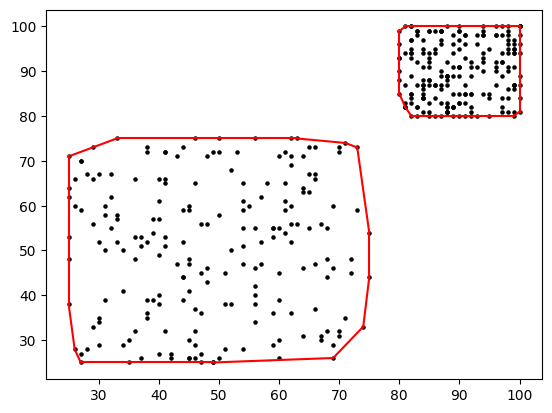

As envoltórias convexas se intersectam.


In [536]:
p1 = geraPontos(200, (80,100))
env1 = envoltoriaConvexa(p1)
desenhaEnvoltoria(env1, p1)

p2 = geraPontos(200, (25,75))
env2 = envoltoriaConvexa(p2)
desenhaEnvoltoria(env2, p2)

plt.show()

segmentosVarredura = preparaSegmentos(env1, env2)

intersecao = varreduraLinear(segmentosVarredura)

if intersecao:
    print("As envoltórias convexas se intersectam.")
else:
    print("As envoltórias convexas não se intersectam.")

# 4. Modelo de Classificação

Com as duas envoltórias em mãos e o conhecimento de elas não têm sobreposição, podemos definir o `modelo de classificação linear`.

Isto será feito ao encontrarmos uma linha (ou melhor, a equação de uma linha) que separe ambos os conjuntos.

>**Descrição do algoritmo:**
> 1. Encontrando os pontos mais próximos de cada envoltória
> 2. Encontrar o ponto médio na reta que liga estes dois pontos, onde a reta passará.
> 3. Encontrar a reta de separação dos conjuntos, que deverá ser tangente à reta que liga os pontos mais próximos e passar através do ponto médio.

Primeiro precisamos **encontrar os pontos mais próximos de cada envoltória**, ou seja, o par de pontos que têm a menor distância e que sejam de contornos diferentes.

`Uma abordagem quadrática foi tomada`, comparando todos os pares possíveis de pontos. Apesar de outras técnicas terem sido consideradas, como bibliotecas de python que usariam o algoritmo mais eficiente de Gilbert-Johnson-Keerthi (que usaria simplex), ou uma possível alteração do algoritmo da seção 22.4 do livro Algorithm Design and Applications (por Goodrich e Tamassia, de 2015), os alunos julgaram que seria o mais rápido de se implementar.

In [537]:
def pontos_mais_proximos(envoltoria1, envoltoria2):
  """Encontra os pontos mais próximos entre dois polígonos convexos."""

  distancia_minima = np.inf
  pontos_mais_proximos = None

  for i in range(len(envoltoria1)):
    for j in range(len(envoltoria2)):
      distancia = np.linalg.norm(np.array(envoltoria1[i]) - np.array(envoltoria2[j]))
      if distancia < distancia_minima:
        distancia_minima = distancia
        pontos_mais_proximos = (envoltoria1[i], envoltoria2[j])

  return pontos_mais_proximos

Em seguida **calculamos o ponto médio entre esses pontos**. Neste caso a divisão é inevitável.

In [538]:
def calcula_ponto_medio(ponto1, ponto2):
  """Calcula o ponto médio entre dois pontos"""
  return ((ponto1[0] + ponto2[0]) / 2, (ponto1[1] + ponto2[1] ) / 2)

Por fim, usamos a informação dos pontos mais próximos e do ponto médio para **encontrar a reta que é tangente à reta entre os pontos**, e que passe pelo ponto médio delas.

**Lembremos da equação de uma reta:** $(a*x + b)$, onde $a$ é a inclinação e $b$ é o coeficiente linear.

In [539]:
def linha_classificadora(envoltoria1, envoltoria2):
  """Calcula um modelo classificador entre duas envoltórias.
  Retorna: Equação da reta (inclinacao, b) que separa as envoltórias
  """
  # O caso em que os pontos sejam iguais não é tratado aqui

  ponto1, ponto2 = pontos_mais_proximos(envoltoria1, envoltoria2)

  dx = ponto2[0] - ponto1[0]
  dy = ponto2[1] - ponto1[1]

  ponto_medio = calcula_ponto_medio(ponto1, ponto2)

  if dx == 0:
    # A reta é vertical, então a tangente é horizontal
    inclinacao = 0
    b = ponto_medio[0]  # O valor de 'b' é a coordenada x do ponto médio
  else:
    inclinacao = dy / dx
    # calcula a inclinação e equação da reta tangente que passa sobre o ponto medio
    if inclinacao == 0:
      inclinacao += 0.0001
    inclinacao_tangente = -1 / inclinacao
    b_tangente = ponto_medio[1] - inclinacao_tangente * ponto_medio[0]

  return (inclinacao_tangente, b_tangente)

**Visualizando os resultados.**
Aqui vamos encontrar os pontos mais próximos, o ponto médio e a equação da reta tangente que desejamos.

Note que as envoltórias são aleatórias, e podem não ser separáveis. Por favor continue re-executando até que um resultado separável ocorra.

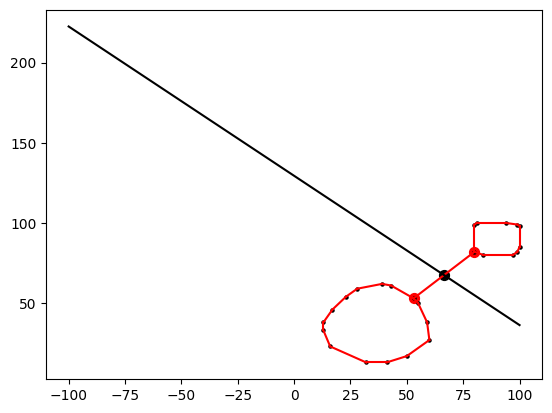

As envoltórias convexas se intersectam.


In [540]:
# Gera dois conjuntos de dados e verifica a separabilidade
env1 = envoltoriaConvexa(geraPontos(200, (80,100)))
env2 = envoltoriaConvexa(geraPontos(200, (25,75)))
intersecta = varreduraLinear(preparaSegmentos(env1,env2))

pontos = pontos_mais_proximos(env1, env2)
ponto_medio = calcula_ponto_medio(pontos[0], pontos[1])
linha = linha_classificadora(env1, env2)

# Plot dos pontos mais próximos e do ponto médio
plt.scatter(*zip(*pontos), s=50, c='red')
plt.scatter(*ponto_medio, s=50, c='black')
plt.plot([pontos[0][0], pontos[1][0]], [pontos[0][1], pontos[1][1]], c='red')

# Plot da reta tangente passando pelo ponto médio
plt.plot([-100, 100], [linha[0] * -100 + linha[1], linha[0] * 100 + linha[1]], c='black')

# Restante do código para plotar as envoltórias
desenhaEnvoltoria(env1)
desenhaEnvoltoria(env2)

plt.show()
if not intersecta:
  print("As envoltórias convexas se intersectam.")

# 5. Classificador e Produtor de Métricas

Com as ferramentas apresentadas em mãos, a `envoltória` a `varredura` e o `modelo classificador`, iremos agora criar uma interface para aplicar estes algoritmos a qualquer conjunto de dados.

A interface escolhida será na forma de uma clase `Classificador`, que será criada a partir de duas bases de dados e irá automaticamente:
- Dividir os dados em conjuntos treinamento/teste
- Produzir o modelo de classificação linear
- Calcular as métricas de precisão para o conjunto de teste

In [541]:
import numpy as np
from sklearn.model_selection import train_test_split

class Classificador:
    def __init__(self, classe1, classe2, label1, label2, test_size=0.2, random_state=None, rodar_automaticamente=True):
        self.classe1 = classe1
        self.classe2 = classe2
        self.label1 = label1
        self.label2 = label2
        self.centroide_classe1 = None
        self.centroide_classe2 = None
        self.treino_classe1 = None
        self.teste_classe1 = None
        self.treino_classe2 = None
        self.teste_classe2 = None
        self.reta_perpendicular = None
        self.intersecao = False

        if rodar_automaticamente:

            # Separar conjuntos de treino e teste
            self.separar_treino_teste(test_size, random_state)

            # Treinar com os conjuntos de treino
            self.treinar()

            if self.intersecao:
              print("Os dados de treinamento de", self.label1, "e", self.label2, "não são separáveis")
            else:
              # Mostra o gráfico
              self.desenha_grafico()

    def setar_treino_teste(self, treino_classe1, teste_classe1, treino_classe2, teste_classe2):
      self.treino_classe1 = treino_classe1
      self.teste_classe1 = teste_classe1
      self.treino_classe2 = treino_classe2
      self.teste_classe2 = teste_classe2

    def separar_treino_teste(self, test_size=0.3, random_state=None):
        self.treino_classe1, self.teste_classe1 = train_test_split(self.classe1, test_size=test_size, random_state=random_state)
        self.treino_classe2, self.teste_classe2 = train_test_split(self.classe2, test_size=test_size, random_state=random_state)

    def treinar(self):
        envoltoria1 = envoltoriaConvexa(self.treino_classe1)
        envoltoria2 = envoltoriaConvexa(self.treino_classe2)

        self.intersecao = varreduraLinear(preparaSegmentos(envoltoria1, envoltoria2))

        self.centroide_classe1 = np.mean(envoltoria1, axis=0)
        self.centroide_classe2 = np.mean(envoltoria2, axis=0)

        self.linha_classificadora = linha_classificadora(envoltoria1, envoltoria2)

    def classificar(self, ponto):
        if self.centroide_classe1 is None or self.centroide_classe2 is None or self.linha_classificadora is None:
            raise ValueError("Os centroides ou a linha classificadora ainda não foram calculados. Execute treinar() primeiro.")

        inclinacao_tangente, b_tangente = self.linha_classificadora

        # Calcular o valor da reta no ponto dado
        valor_da_reta = ponto[1] - (inclinacao_tangente * ponto[0] + b_tangente)

        # Comparar as alturas dos centroides
        altura_centroide_classe1 = self.centroide_classe1[1]
        altura_centroide_classe2 = self.centroide_classe2[1]

        if altura_centroide_classe1 > altura_centroide_classe2:
            return self.label1 if valor_da_reta > 0 else self.label2
        else:
            return self.label2 if valor_da_reta > 0 else self.label1

    def desenha_grafico(self):
        # Calcule as envoltórias convexas
        env1 = envoltoriaConvexa(self.treino_classe1)
        env2 = envoltoriaConvexa(self.treino_classe2)

        # Desenhe as envoltórias convexas
        desenhaEnvoltoria(env1)
        desenhaEnvoltoria(env2)

        # Desenhe os conjuntos de pontos
        #desenha_pontos(self.classe1,self.classe2,self.label1, self.label2)

        if not self.intersecao:
          # Desenha a linha classificadora apenas caso os dados sejam separáveis
          original_xlim = plt.gca().get_xlim()
          original_ylim = plt.gca().get_ylim()

          pontos = pontos_mais_proximos(env1, env2)
          ponto_medio = calcula_ponto_medio(pontos[0], pontos[1])
          linha = linha_classificadora(env1, env2)

          plt.scatter(*zip(*pontos), s=50, c='black')
          plt.scatter(*ponto_medio, s=50, c='black')
          plt.plot([pontos[0][0], pontos[1][0]], [pontos[0][1], pontos[1][1]], c='red')
          plt.plot([pontos[0][0]-100, pontos[1][0]+100], [linha[0] * (pontos[0][0]-100) + linha[1], linha[0] * (pontos[1][0]+100) + linha[1]], c='black')

          plt.xlim(original_xlim)
          plt.ylim(original_ylim)

        plt.xlabel('Componente 1')
        plt.ylabel('Componente 2')
        plt.title('Iris dataset com 2 componentes')

        plt.show()

    def exibir_metricas(self):
        if self.intersecao:
          print("Não há como realizar métricas pois os dados de treinamento das classes", self.label1, "e", self.label2, "não são separáveis")
          print("")
          return

        acertos_treino = 0
        erros_treino = 0
        acertos_teste = 0
        erros_teste = 0

        if self.treino_classe1 is not None and self.treino_classe2 is not None:
            for ponto in self.treino_classe1:
                if self.classificar(ponto) == self.label1:
                    acertos_treino += 1
                else:
                    erros_treino += 1
            for ponto in self.treino_classe2:
                if self.classificar(ponto) == self.label2:
                    acertos_treino += 1
                else:
                    erros_treino += 1

        if self.teste_classe1 is not None and self.teste_classe2 is not None:
            for ponto in self.teste_classe1:
                if self.classificar(ponto) == self.label1:
                    acertos_teste += 1
                else:
                    erros_teste += 1
            for ponto in self.teste_classe2:
                if self.classificar(ponto) == self.label2:
                    acertos_teste += 1
                else:
                    erros_teste += 1

        total_acertos = acertos_treino + acertos_teste
        total_erros = erros_treino + erros_teste

        # Calcular os verdadeiros positivos, falsos positivos e falsos negativos
        verdadeiros_positivos = acertos_teste
        falsos_positivos = erros_teste  # Supondo que tudo o que foi classificado como classe 2 e era classe 1 seja um falso positivo
        falsos_negativos = erros_treino  # Supondo que tudo o que não foi classificado como classe 2 e era classe 1 seja um falso negativo

        # Calcular precisão e revocação
        precisao = verdadeiros_positivos / (verdadeiros_positivos + falsos_positivos)
        revocacao = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos)

        indice_acerto = total_acertos / (total_acertos + total_erros) * 100

        print("Para a classificação entre", self.label1, "e", self.label2, "temos que:")

        print("Se interceptam:", self.intersecao)

        print("Porcentagem de acertos (treino):", (acertos_treino / (acertos_treino + erros_treino)) * 100)
        print("Porcentagem de erros (treino):", (erros_treino / (acertos_treino + erros_treino)) * 100)
        print("Porcentagem de acertos (teste):", (acertos_teste / (acertos_teste + erros_teste)) * 100)
        print("Porcentagem de erros (teste):", (erros_teste / (acertos_teste + erros_teste)) * 100)
        print("Índice de acerto:", indice_acerto, "%")
        print("Precisão:", precisao)
        print("Revocação:", revocacao)
        print("")

**Visualizando os resultados.**

Note que as envoltórias são aleatórias, e podem não ser separáveis. Por favor continue re-executando até que um resultado separável ocorra.

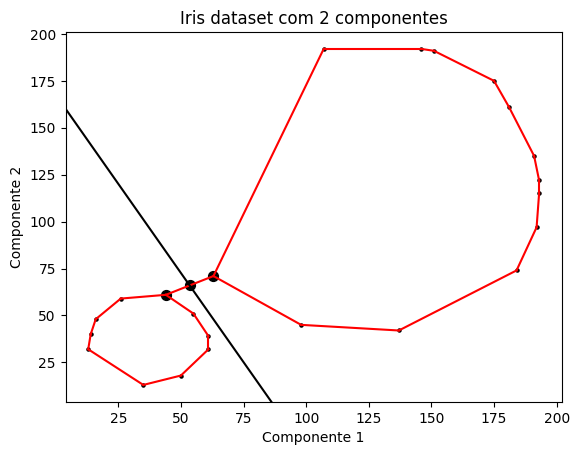

In [542]:
# Gera dois conjuntos de dados e verifica a separabilidade
env1 = envoltoriaConvexa(geraPontos(200, (80,100)))
env2 = envoltoriaConvexa(geraPontos(200, (25,75)))

Classificador(env1,env2,"classe1","classe2")

# 6. Definição dos datasets

## Iris Dataset

O conjunto de dados `Iris` contém informações sobre três espécies de flores Iris, sendo elas: Setosa, Versicolor e Virginica. Para cada espécie, quatro características botânicas são registradas: o comprimento e largura das sépalas e o comprimento e largura das pétalas.

In [543]:
from sklearn.datasets import load_iris
iris = load_iris()

pd.DataFrame(iris.data).head(2)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


In [544]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
iris_2d = svd.fit_transform(iris.data)

setosa_points = iris_2d[iris.target == 0]
versicolor_points = iris_2d[iris.target == 1]
virginica_points = iris_2d[iris.target == 2]

## Wine dataset
O conjunto de dados `Wine` contém informações sobre três tipos de vinhos. Para cada vinho, temos dadods como teor alcoólico, acidez, intensidade da cor, entre outros. No total são 13 atributos, todos numéricos.

In [545]:
from sklearn.datasets import load_wine
wine = load_wine()

pd.DataFrame(wine.data).head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0


In [546]:
svd = TruncatedSVD(n_components=2)
wine_2d = svd.fit_transform(wine.data)

wine_classe0 = wine_2d[wine.target == 0]
wine_classe1 = wine_2d[wine.target == 1]
wine_classe2 = wine_2d[wine.target == 2]

# Avaliação das Métricas

Por fim, vamos calcular diversas métricas e analisar o resultado.

## Teste 1 - Classes Setosa e Versicolor

Os dados das classes Setosa e Versicolor são bem separados, não se sobrepõem.
O modelo obteve uma taxa de acerto de 100% tanto no treinamento quanto no teste.
A precisão e revocação também são ideais, com valores de 1.0.

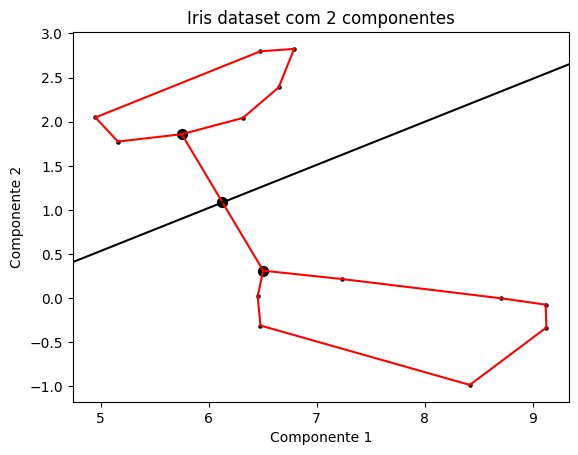

Para a classificação entre setosa e versicolor temos que:
Se interceptam: False
Porcentagem de acertos (treino): 100.0
Porcentagem de erros (treino): 0.0
Porcentagem de acertos (teste): 100.0
Porcentagem de erros (teste): 0.0
Índice de acerto: 100.0 %
Precisão: 1.0
Revocação: 1.0



In [547]:
teste1 = Classificador(setosa_points,versicolor_points,"setosa","versicolor")
teste1.exibir_metricas()

## Teste 2 - Classes Virginica e Versicolor
As classes Virginica e Versicolor têm uma sobreposição considerável, e não são linearmente separáveis. Por causa disso, o modelo não foi calculado e as métricas não foram feitas.

In [548]:
teste2 = Classificador(virginica_points,versicolor_points,"virginica","versicolor")
teste2.exibir_metricas()

Os dados de treinamento de virginica e versicolor não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes virginica e versicolor não são separáveis



## Teste 3 - Classes Setosa e Virginica
Assim como a Setosa e a Versicolor, as classes Setosa e Virginica são bem separadas.
O modelo obteve uma taxa de acerto de 100% tanto no treinamento quanto no teste.
A precisão e revocação também são ideais, com valores de 1.0.

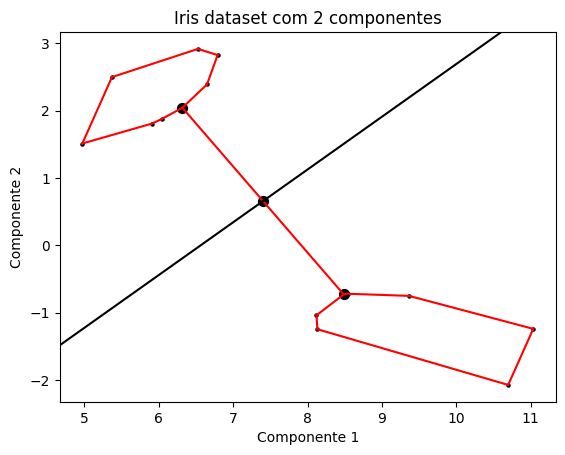

Para a classificação entre setosa e virginica temos que:
Se interceptam: False
Porcentagem de acertos (treino): 100.0
Porcentagem de erros (treino): 0.0
Porcentagem de acertos (teste): 100.0
Porcentagem de erros (teste): 0.0
Índice de acerto: 100.0 %
Precisão: 1.0
Revocação: 1.0



In [549]:
teste3 = Classificador(setosa_points,virginica_points,"setosa","virginica")
teste3.exibir_metricas()

Os resultados destes três primeiros testes indicam que o modelo foi altamente eficaz no dataset iris, separando corretamente os dados quando separáveis e indentificando quando não são.

Os próximos 3 testes foram feitos com a base de dados wine, e mostram diferentes casos de interseção de envoltórias

## Teste 4 - Classes 0 e 1

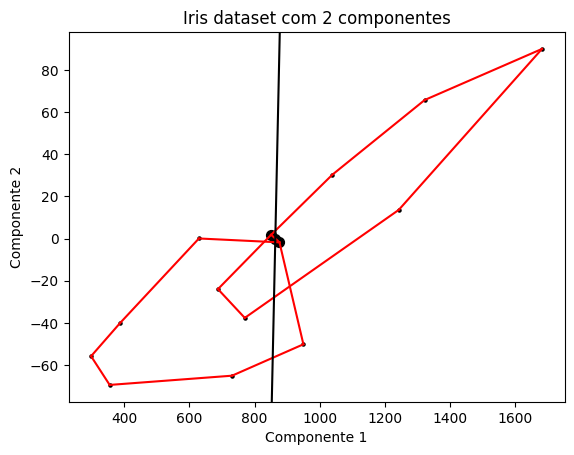

Para a classificação entre wine_0 e wine_1 temos que:
Se interceptam: False
Porcentagem de acertos (treino): 8.737864077669903
Porcentagem de erros (treino): 91.2621359223301
Porcentagem de acertos (teste): 14.814814814814813
Porcentagem de erros (teste): 85.18518518518519
Índice de acerto: 10.0 %
Precisão: 0.14814814814814814
Revocação: 0.04081632653061224



In [550]:
teste4 = Classificador(wine_classe0, wine_classe1, "wine_0", "wine_1")
teste4.exibir_metricas()

## Teste 5 - Classes 0 e 2

In [551]:
teste5 = Classificador(wine_classe0, wine_classe2, "wine_0", "wine_2")
teste5.exibir_metricas()

Os dados de treinamento de wine_0 e wine_2 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_0 e wine_2 não são separáveis



## Teste 6 - Classes 1 e 2

In [552]:
teste6 = Classificador(wine_classe1, wine_classe2, "wine_1", "wine_2")
teste6.exibir_metricas()

Os dados de treinamento de wine_1 e wine_2 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_1 e wine_2 não são separáveis



## Teste 7

In [553]:
wine = load_wine()

wine_data = wine.data

wine_data = wine_data[:, [2,4,6,10]]

svd = TruncatedSVD(n_components=2)
wine_teste7 = svd.fit_transform(wine_data)

wine_teste7_0 = wine_teste7[wine.target == 0]
wine_teste7_1 = wine_teste7[wine.target == 1]
wine_teste7_2 = wine_teste7[wine.target == 2]

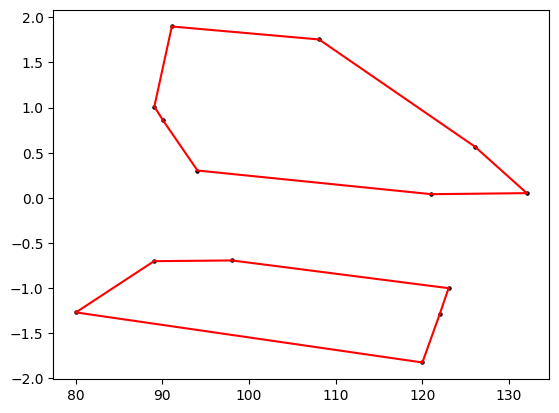

True

In [554]:
e0 = envoltoriaConvexa(wine_teste7_0)
e2 = envoltoriaConvexa(wine_teste7_2)

desenhaEnvoltoria(e0)
desenhaEnvoltoria(e2)
plt.show()

varreduraLinear(preparaSegmentos(e0,e2))

In [555]:
teste7 = Classificador(wine_teste7_0, wine_teste7_2, "wine_teste7_0", "wine_teste7_2")
teste7.exibir_metricas()

Os dados de treinamento de wine_teste7_0 e wine_teste7_2 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_teste7_0 e wine_teste7_2 não são separáveis



## Teste 4 - Wine alterado
Agora, testaremos alguns casos em que os dados de treinamento são selecionados manualmente para gerar viés no classificador.

Nesse teste, alteramos arbitrariamente o dataset `Wine` para gerar um classificador enviesado.

Primeiramente, selecionamos as 6 primeiras colunas do dataset, e filtramos apenas as classes 0 e 2. Assim, temos um gráfico propenso ao viés. Note que os dados se interceptam, mas escolheremos o conjunto de treinamento de modo que forme envoltórias separáveis.

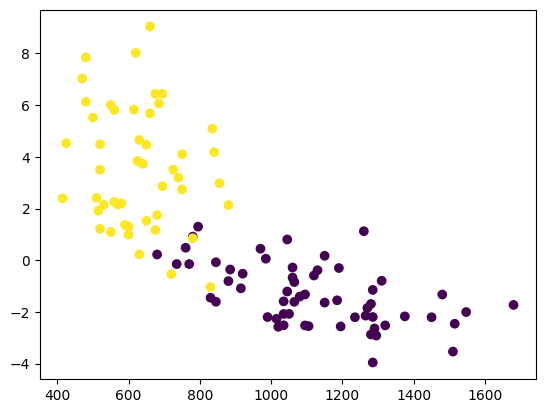

In [556]:
wine_data = wine.data

wine_data = wine_data[:, 6:]

svd = TruncatedSVD(n_components=2)
wine_teste4 = svd.fit_transform(wine_data)

wine_teste4 = wine_teste4[wine.target != 1]
wine.target = wine.target[wine.target != 1]

plt.scatter(wine_teste4[:, 0], wine_teste4[:, 1], c=wine.target)
plt.show()

Para gerar os dados de treinamento, iremos separar da classe 0 (roxa) os dados com as coordenadas `x > 900` e `y < 0`. Da classe 1 (amarela), separaremos para treinamento os dados com coordenadas `y > 2`. Assim, podemos ver que os dados de treinamento são separáveis, e poderemos verificar a taxa de erros do modelo gerado.

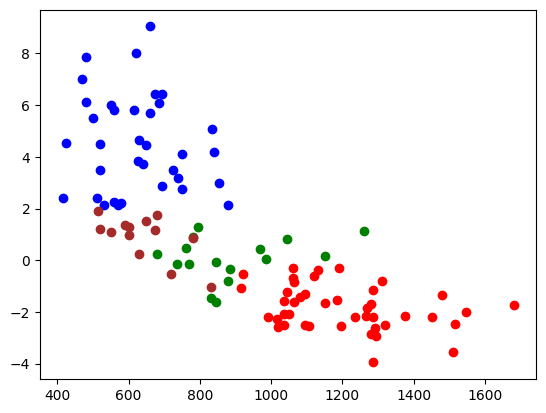

In [557]:
classe0 = wine_teste4[wine.target == 0]
classe2 = wine_teste4[wine.target == 2]

treinamento1 = classe0[classe0[:, 0] > 900]
linhas = treinamento1[:, 1] < 0

testes1 = np.concatenate([classe0[classe0[:, 0] < 900], treinamento1[~linhas]])
treinamento1 = treinamento1[linhas]

treinamento2 = classe2[classe2[:, 1] > 2]
testes2 = classe2[classe2[:, 1] < 2]

plt.scatter(treinamento1[:, 0], treinamento1[:, 1], c='red')
plt.scatter(testes1[:, 0], testes1[:, 1], c='green')
plt.scatter(treinamento2[:, 0], treinamento2[:, 1], c='blue')
plt.scatter(testes2[:, 0], testes2[:, 1], c='brown')
plt.show()

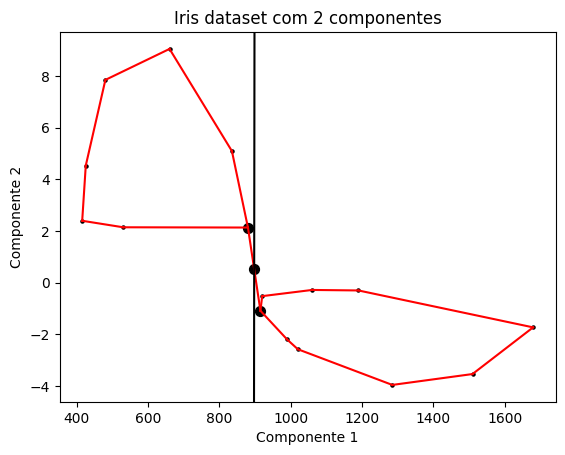

Para a classificação entre Classe 0 e Classe 2 temos que:
Se interceptam: False
Porcentagem de acertos (treino): 100.0
Porcentagem de erros (treino): 0.0
Porcentagem de acertos (teste): 62.06896551724138
Porcentagem de erros (teste): 37.93103448275862
Índice de acerto: 89.7196261682243 %
Precisão: 0.6206896551724138
Revocação: 1.0



In [558]:
teste = Classificador(classe0, classe2, "Classe 0", "Classe 2", rodar_automaticamente=False)

teste.setar_treino_teste(treinamento1, testes1, treinamento2, testes2)
teste.treinar()

if teste.intersecao:
  print("Os dados de treinamento das classes 0 e 2 não são separáveis")

teste.desenha_grafico()
teste.exibir_metricas()

## Teste 5

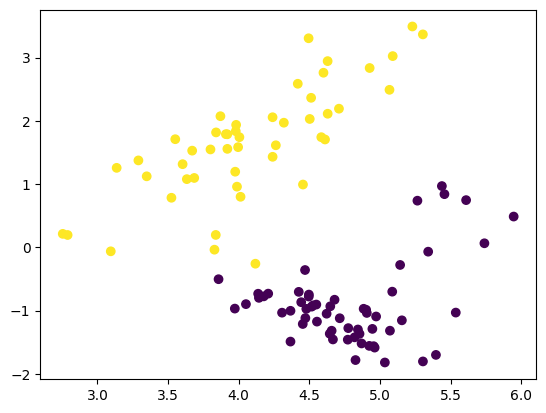

In [559]:
wine = load_wine()

wine_data = wine.data

wine_data = wine_data[:, [1,2,6,8,10]]

svd = TruncatedSVD(n_components=2)
wine_teste5 = svd.fit_transform(wine_data)

wine_teste5 = wine_teste5[wine.target != 1]
wine.target = wine.target[wine.target != 1]

plt.scatter(wine_teste5[:, 0], wine_teste5[:, 1], c=wine.target)
plt.show()

In [560]:
teste = Classificador(wine_teste5[wine.target == 0], wine_teste5[wine.target == 2], "Classe 0", "Classe 2")

Os dados de treinamento de Classe 0 e Classe 2 não são separáveis
